<a href="https://colab.research.google.com/github/EmiliaNahapetyan/CNN_homework/blob/main/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import precision_score, recall_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f" Using: {device}")

 Using: cuda:0


In [ ]:
def load_cifar10_data(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes

batch_size = 128
trainloader, testloader, classes = load_cifar10_data(batch_size)
print(f"Dataset is loaded: {len(trainloader)} training batches, {len(testloader)} test batches")

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Dataset is loaded: 391 training batches, 79 test batches


In [ ]:
def setup_model(model_name="resnet18"):
    if model_name == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        model.classifier[6] = nn.Linear(4096, 10)
    elif model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, 10)
    else:
        raise ValueError("Model must be 'vgg16' or 'resnet18'")

    if model_name == "vgg16":
        model.avgpool = nn.AdaptiveAvgPool2d((7, 7))

    return model.to(device)


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = dataloaders['train']
            else:
                model.eval()
                dataloader = dataloaders['val']

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader, desc=f'{phase} batches'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
def find_best_hyperparams():
    learning_rates = [0.01, 0.001]
    batch_sizes = [64, 128]
    models = ["resnet18", "vgg16"]
    optimizers = ["sgd", "adam"]

    best_val_acc = 0
    best_params = {}

    results = []

    for model_name in models:
        for lr in learning_rates:
            for opt_name in optimizers:

                print(f"\nTesting: model={model_name}, lr={lr}, optimizer={opt_name}")

                trainloader, testloader, classes = load_cifar10_data(batch_size=128)
                dataloaders = {'train': trainloader, 'val': testloader}

                model = setup_model(model_name)

                criterion = nn.CrossEntropyLoss()

                if opt_name == "sgd":
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
                else:
                    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

                scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

                model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=5)

                val_acc = history['val_acc'][-1]
                results.append({
                    'model': model_name,
                    'lr': lr,
                    'optimizer': opt_name,
                    'val_acc': val_acc
                })

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_params = {
                        'model': model_name,
                        'lr': lr,
                        'optimizer': opt_name
                    }

    print("\nHyperparameter search results:")
    for result in results:
        print(f"Model: {result['model']}, LR: {result['lr']}, Optimizer: {result['optimizer']} -> Val Acc: {result['val_acc']:.4f}")

    print(f"\nBest hyperparameter combination:: {best_params}, Val Acc: {best_val_acc:.4f}")
    return best_params

In [ ]:
def evaluate_model(model, testloader, classes):
    model.eval()

    all_preds = []
    all_labels = []

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy on test dataset: {accuracy:.2f}%')

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

    return accuracy, precision, recall



In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()


In [ ]:
def save_model(model, save_path='best_model.pth'):
    torch.save(model.state_dict(), save_path)
    print(f'Model is saved: {save_path}')


def load_model(model_name, model_path='best_model.pth'):
    model = setup_model(model_name)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print(f'Model is loaded: {model_path}')
    return model


In [ ]:
def predict_image(model, image_path, classes, transform=None):
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])

    img = torchvision.io.read_image(image_path).float() / 255.0
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        prob = F.softmax(outputs, dim=1)

    print(f'Image is classified as: {classes[predicted.item()]}')
    print(f'Probability: {prob[0][predicted.item()]:.4f}')

    return classes[predicted.item()], prob[0]


Hyperparameter search։

Testing: model=resnet18, lr=0.01, optimizer=sgd


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:24<00:00, 15.99it/s]


train Loss: 1.0338 Acc: 0.6437


val batches: 100%|██████████| 79/79 [00:02<00:00, 29.92it/s]


val Loss: 0.7575 Acc: 0.7406

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.57it/s]


train Loss: 0.7166 Acc: 0.7557


val batches: 100%|██████████| 79/79 [00:02<00:00, 31.24it/s]


val Loss: 0.6389 Acc: 0.7827

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 17.79it/s]


train Loss: 0.6315 Acc: 0.7856


val batches: 100%|██████████| 79/79 [00:03<00:00, 25.89it/s]


val Loss: 0.6032 Acc: 0.7953

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 17.94it/s]


train Loss: 0.5815 Acc: 0.8012


val batches: 100%|██████████| 79/79 [00:03<00:00, 23.43it/s]


val Loss: 0.5537 Acc: 0.8090

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 18.49it/s]


train Loss: 0.5330 Acc: 0.8154


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.53it/s]


val Loss: 0.5624 Acc: 0.8125

Training completed in 2m 7s
Best val Acc: 0.812500

Testing: model=resnet18, lr=0.01, optimizer=adam
Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s]


train Loss: 2.0699 Acc: 0.2635


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s]


val Loss: 1.6374 Acc: 0.3554

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s]


train Loss: 1.5152 Acc: 0.4354


val batches: 100%|██████████| 79/79 [00:03<00:00, 21.61it/s]


val Loss: 1.4935 Acc: 0.4608

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s]


train Loss: 1.3376 Acc: 0.5140


val batches: 100%|██████████| 79/79 [00:03<00:00, 21.71it/s]


val Loss: 1.6728 Acc: 0.4298

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.57it/s]


train Loss: 1.2449 Acc: 0.5528


val batches: 100%|██████████| 79/79 [00:03<00:00, 21.55it/s]


val Loss: 1.2809 Acc: 0.5387

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.62it/s]


train Loss: 1.1923 Acc: 0.5717


val batches: 100%|██████████| 79/79 [00:03<00:00, 21.77it/s]


val Loss: 1.3254 Acc: 0.5210

Training completed in 2m 8s
Best val Acc: 0.538700

Testing: model=resnet18, lr=0.001, optimizer=sgd
Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s]


train Loss: 1.3104 Acc: 0.5356


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.92it/s]


val Loss: 0.9552 Acc: 0.6632

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 18.45it/s]


train Loss: 0.8900 Acc: 0.6870


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.85it/s]


val Loss: 0.7785 Acc: 0.7269

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s]


train Loss: 0.7693 Acc: 0.7315


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.21it/s]


val Loss: 0.7075 Acc: 0.7546

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s]


train Loss: 0.6897 Acc: 0.7582


val batches: 100%|██████████| 79/79 [00:03<00:00, 23.66it/s]


val Loss: 0.6640 Acc: 0.7716

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s]


train Loss: 0.6408 Acc: 0.7763


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.37it/s]


val Loss: 0.6198 Acc: 0.7867

Training completed in 2m 5s
Best val Acc: 0.786700

Testing: model=resnet18, lr=0.001, optimizer=adam
Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.77it/s]


train Loss: 1.0337 Acc: 0.6462


val batches: 100%|██████████| 79/79 [00:03<00:00, 21.70it/s]


val Loss: 0.8171 Acc: 0.7279

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s]


train Loss: 0.7635 Acc: 0.7405


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.56it/s]


val Loss: 0.6971 Acc: 0.7593

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s]


train Loss: 0.6895 Acc: 0.7663


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.78it/s]


val Loss: 0.6864 Acc: 0.7717

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s]


train Loss: 0.6510 Acc: 0.7796


val batches: 100%|██████████| 79/79 [00:03<00:00, 24.99it/s]


val Loss: 0.7070 Acc: 0.7674

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s]


train Loss: 0.6166 Acc: 0.7911


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.63it/s]


val Loss: 0.6558 Acc: 0.7757

Training completed in 2m 8s
Best val Acc: 0.775700

Testing: model=vgg16, lr=0.01, optimizer=sgd


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 64.4MB/s]


Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]


train Loss: 0.8949 Acc: 0.6964


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.79it/s]


val Loss: 0.5967 Acc: 0.8037

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:38<00:00, 10.05it/s]


train Loss: 0.5403 Acc: 0.8219


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s]


val Loss: 0.5409 Acc: 0.8229

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]


train Loss: 0.4310 Acc: 0.8586


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.37it/s]


val Loss: 0.4649 Acc: 0.8508

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00, 10.01it/s]


train Loss: 0.3687 Acc: 0.8778


val batches: 100%|██████████| 79/79 [00:03<00:00, 20.11it/s]


val Loss: 0.4110 Acc: 0.8679

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]


train Loss: 0.3305 Acc: 0.8900


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.59it/s]


val Loss: 0.3805 Acc: 0.8711

Training completed in 3m 32s
Best val Acc: 0.871100

Testing: model=vgg16, lr=0.01, optimizer=adam
Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s]


train Loss: 566859.6153 Acc: 0.0996


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.65it/s]


val Loss: 2.3029 Acc: 0.1000

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.44it/s]


train Loss: 2528.1483 Acc: 0.0970


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.93it/s]


val Loss: 2.3030 Acc: 0.1000

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


train Loss: 812220.8241 Acc: 0.1018


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.53it/s]


val Loss: 2.3036 Acc: 0.1000

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.42it/s]


train Loss: 105040419268382528.0000 Acc: 0.1018


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.59it/s]


val Loss: 2.3032 Acc: 0.1000

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.47it/s]


train Loss: 42513049.4235 Acc: 0.1005


val batches: 100%|██████████| 79/79 [00:03<00:00, 20.13it/s]


val Loss: 2.3036 Acc: 0.1000

Training completed in 4m 8s
Best val Acc: 0.100000

Testing: model=vgg16, lr=0.001, optimizer=sgd
Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


train Loss: 1.0017 Acc: 0.6459


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.09it/s]


val Loss: 0.6625 Acc: 0.7698

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00, 10.00it/s]


train Loss: 0.6213 Acc: 0.7868


val batches: 100%|██████████| 79/79 [00:03<00:00, 24.18it/s]


val Loss: 0.5475 Acc: 0.8128

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]


train Loss: 0.5219 Acc: 0.8219


val batches: 100%|██████████| 79/79 [00:03<00:00, 25.10it/s]


val Loss: 0.4730 Acc: 0.8355

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]


train Loss: 0.4624 Acc: 0.8404


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.19it/s]


val Loss: 0.5154 Acc: 0.8254

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


train Loss: 0.4252 Acc: 0.8545


val batches: 100%|██████████| 79/79 [00:02<00:00, 28.36it/s]


val Loss: 0.4147 Acc: 0.8571

Training completed in 3m 31s
Best val Acc: 0.857100

Testing: model=vgg16, lr=0.001, optimizer=adam
Epoch 1/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


train Loss: 1.9296 Acc: 0.2172


val batches: 100%|██████████| 79/79 [00:03<00:00, 21.08it/s]


val Loss: 1.6340 Acc: 0.3279

Epoch 2/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.36it/s]


train Loss: 1.3749 Acc: 0.4407


val batches: 100%|██████████| 79/79 [00:03<00:00, 20.91it/s]


val Loss: 1.1241 Acc: 0.5761

Epoch 3/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


train Loss: 1.0386 Acc: 0.6290


val batches: 100%|██████████| 79/79 [00:03<00:00, 20.54it/s]


val Loss: 0.8686 Acc: 0.7037

Epoch 4/5
----------


train batches: 100%|██████████| 391/391 [00:47<00:00,  8.31it/s]


train Loss: 0.8601 Acc: 0.7117


val batches: 100%|██████████| 79/79 [00:03<00:00, 20.91it/s]


val Loss: 0.7668 Acc: 0.7404

Epoch 5/5
----------


train batches: 100%|██████████| 391/391 [00:46<00:00,  8.33it/s]


train Loss: 0.7476 Acc: 0.7586


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.37it/s]


val Loss: 0.7288 Acc: 0.7782

Training completed in 4m 13s
Best val Acc: 0.778200

Hyperparameter search results:
Model: resnet18, LR: 0.01, Optimizer: sgd -> Val Acc: 0.8125
Model: resnet18, LR: 0.01, Optimizer: adam -> Val Acc: 0.5210
Model: resnet18, LR: 0.001, Optimizer: sgd -> Val Acc: 0.7867
Model: resnet18, LR: 0.001, Optimizer: adam -> Val Acc: 0.7757
Model: vgg16, LR: 0.01, Optimizer: sgd -> Val Acc: 0.8711
Model: vgg16, LR: 0.01, Optimizer: adam -> Val Acc: 0.1000
Model: vgg16, LR: 0.001, Optimizer: sgd -> Val Acc: 0.8571
Model: vgg16, LR: 0.001, Optimizer: adam -> Val Acc: 0.7782

Best hyperparameter combination:: {'model': 'vgg16', 'lr': 0.01, 'optimizer': 'sgd'}, Val Acc: 0.8711

Train the final model with the best hyperparameters։
Epoch 1/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


train Loss: 0.8646 Acc: 0.7101


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.39it/s]


val Loss: 0.5522 Acc: 0.8189

Epoch 2/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]


train Loss: 0.5261 Acc: 0.8246


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.53it/s]


val Loss: 0.5109 Acc: 0.8286

Epoch 3/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


train Loss: 0.4340 Acc: 0.8556


val batches: 100%|██████████| 79/79 [00:03<00:00, 23.92it/s]


val Loss: 0.4587 Acc: 0.8484

Epoch 4/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]


train Loss: 0.3660 Acc: 0.8775


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.96it/s]


val Loss: 0.3844 Acc: 0.8699

Epoch 5/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s]


train Loss: 0.3242 Acc: 0.8909


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.62it/s]


val Loss: 0.4241 Acc: 0.8586

Epoch 6/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


train Loss: 0.2885 Acc: 0.9029


val batches: 100%|██████████| 79/79 [00:03<00:00, 20.40it/s]


val Loss: 0.3617 Acc: 0.8799

Epoch 7/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


train Loss: 0.2590 Acc: 0.9128


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.16it/s]


val Loss: 0.3329 Acc: 0.8883

Epoch 8/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.97it/s]


train Loss: 0.2430 Acc: 0.9195


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.56it/s]


val Loss: 0.3802 Acc: 0.8752

Epoch 9/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


train Loss: 0.2252 Acc: 0.9240


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.77it/s]


val Loss: 0.3325 Acc: 0.8905

Epoch 10/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]


train Loss: 0.2094 Acc: 0.9298


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.34it/s]


val Loss: 0.3354 Acc: 0.8899

Epoch 11/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]


train Loss: 0.1942 Acc: 0.9336


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s]


val Loss: 0.3260 Acc: 0.8923

Epoch 12/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]


train Loss: 0.1808 Acc: 0.9391


val batches: 100%|██████████| 79/79 [00:03<00:00, 24.95it/s]


val Loss: 0.3410 Acc: 0.8927

Epoch 13/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]


train Loss: 0.1753 Acc: 0.9412


val batches: 100%|██████████| 79/79 [00:03<00:00, 25.10it/s]


val Loss: 0.3543 Acc: 0.8929

Epoch 14/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


train Loss: 0.1646 Acc: 0.9446


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.02it/s]


val Loss: 0.3274 Acc: 0.9002

Epoch 15/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


train Loss: 0.1626 Acc: 0.9462


val batches: 100%|██████████| 79/79 [00:02<00:00, 26.95it/s]


val Loss: 0.3484 Acc: 0.8967

Epoch 16/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]


train Loss: 0.1481 Acc: 0.9489


val batches: 100%|██████████| 79/79 [00:03<00:00, 24.39it/s]


val Loss: 0.3148 Acc: 0.9021

Epoch 17/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


train Loss: 0.1448 Acc: 0.9512


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.29it/s]


val Loss: 0.3027 Acc: 0.9093

Epoch 18/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


train Loss: 0.1384 Acc: 0.9538


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.09it/s]


val Loss: 0.3286 Acc: 0.9015

Epoch 19/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]


train Loss: 0.1321 Acc: 0.9554


val batches: 100%|██████████| 79/79 [00:03<00:00, 22.46it/s]


val Loss: 0.3062 Acc: 0.9076

Epoch 20/20
----------


train batches: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]


train Loss: 0.1302 Acc: 0.9562


val batches: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s]


val Loss: 0.3332 Acc: 0.8999

Training completed in 14m 8s
Best val Acc: 0.909300


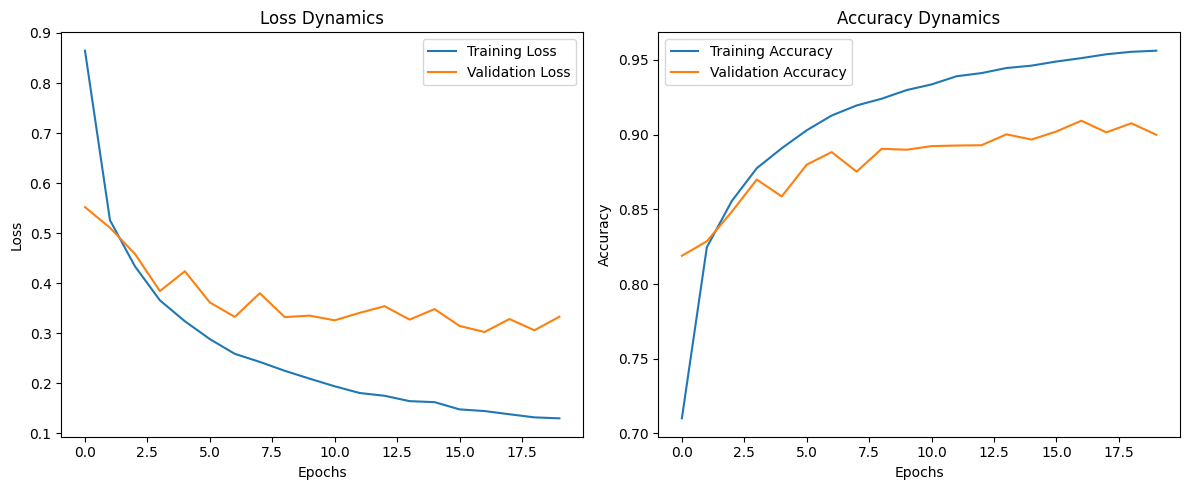


Evaluation․


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 27.35it/s]


Accuracy on test dataset: 90.93%
Precision: 0.9099
Recall: 0.9093
Model is saved: best_vgg16_model.pth

Prediction for test image.

Successfully completed!


In [ ]:
def main():
    print("Hyperparameter search։")
    best_params = find_best_hyperparams()

    print("\nTrain the final model with the best hyperparameters։")

    model_name = best_params['model']
    lr = best_params['lr']
    optimizer_name = best_params['optimizer']

    batch_size = 128
    trainloader, testloader, classes = load_cifar10_data(batch_size)
    dataloaders = {'train': trainloader, 'val': testloader}

    model = setup_model(model_name)

    criterion = nn.CrossEntropyLoss()

    if optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    model, history = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=20)

    plot_training_history(history)

    print("\nEvaluation․")
    accuracy, precision, recall = evaluate_model(model, testloader, classes)

    save_model(model, f'best_{model_name}_model.pth')

    print("\nPrediction for test image.")

    print("\nSuccessfully completed!")


if __name__ == "__main__":
    main()